In [1]:
device = 'cpu'

In [2]:
import warnings
warnings.filterwarnings("ignore")

try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_PREFIX = '/content/drive/MyDrive/m1p'

    IN_COLAB = True
except:
    IN_COLAB = False


Mounted at /content/drive


In [3]:
if IN_COLAB:
    prefix = DRIVE_PREFIX
else:
    prefix = '.'

measurements_path = f'{prefix}/time_measurements/ResNet18HomeMeasurements.csv'
model_path = f'{prefix}/pretrained/model_23.ckpt'

In [4]:
if IN_COLAB:
    ! git clone -qq https://github.com/intsystems/2023-Problem-140.git
    import sys
    sys.path.append('2023-Problem-140/src')


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time

from tqdm import tqdm

import torch
import torch.fx
from torch.fx.node import Node

from typing import Dict

from mylib.nas.resnet18 import ResNet18
from mylib.nas.cifar_data import get_dataloaders

Будем измерять время исполнение с помощью класса интерпретатора:

In [6]:
measurments = dict() # { str(node) : [t1, t2, ...] }


class GraphMeasurer(torch.nn.Module):
    """
    see torch.fx shape propagation
    """
    def __init__(self, mod):
        super(GraphMeasurer, self).__init__()
        try:
            mod.graph
        except:
            mod = torch.fx.symbolic_trace(mod)
        self.mod = mod
        self.graph = mod.graph
        self.modules = dict(self.mod.named_modules())

    def forward(self, *args, intermediate=False):
        args_iter = iter(args)
        env : Dict[str, Node] = {}

        def load_arg(a):
            return torch.fx.graph.map_arg(a, lambda n: env[n.name])

        def fetch_attr(target : str):
            target_atoms = target.split('.')
            attr_itr = self.mod
            for i, atom in enumerate(target_atoms):
                if not hasattr(attr_itr, atom):
                    raise RuntimeError(f"Node referenced nonexistant target {'.'.join(target_atoms[:i])}")
                attr_itr = getattr(attr_itr, atom)
            return attr_itr

        for node in self.graph.nodes:
            if node.op == 'placeholder':
                result = next(args_iter)
            elif node.op == 'get_attr':
                result = fetch_attr(node.target)
            elif node.op == 'call_function':
                result = node.target(*load_arg(node.args), **load_arg(node.kwargs))
            elif node.op == 'call_method':
                self_obj, *args = load_arg(node.args)
                kwargs = load_arg(node.kwargs)
                result = getattr(self_obj, node.target)(*args, **kwargs)
            elif node.op == 'call_module':
                start_time = time.perf_counter_ns()
                result = self.modules[node.target](*load_arg(node.args), **load_arg(node.kwargs))
                end_time = time.perf_counter_ns()
                measurments.setdefault(str(node), []).append(end_time - start_time)
            if node.op == 'output':
                if intermediate:
                    return result, env
                return result
            env[node.name] = result

        return result

Загрузим предобученную модель и замерим время исполнения:

In [7]:
model = ResNet18(num_classes=10)
model.load_state_dict(torch.load(model_path))

imodel = GraphMeasurer(model.eval()).to(device)

train_dl, test_dl = get_dataloaders(classes=range(10), batch_size=64, img_size=33)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 266MB/s]


100%|██████████| 170498071/170498071 [00:03<00:00, 49158013.25it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
for i, (X, _) in tqdm(enumerate(test_dl), 'measuring', total=len(test_dl)):
        if X.shape[0] != 64:
            continue
        imodel(X.to(device))

measuring: 100%|██████████| 157/157 [00:23<00:00,  6.58it/s]


Посчитаем статистики и сохраним результат

In [9]:
data = {
    'node'  : [],
    'mean'  : [],
    'std'   : [],
    'len'   : [],
    'min'   : [],
    '25%'   : [],
    'median': [],
    '75%'   : [],
    'max'   : [],
}

for k, v in measurments.items():
    data['node'].append(k)
    data['mean'].append(np.mean(v))
    data['std'].append(np.std(v))
    data['len'].append(len(v))
    data['min'].append(np.min(v))
    data['25%'].append(np.quantile(v, 0.25))
    data['median'].append(np.median(v))
    data['75%'].append(np.quantile(v, 0.75))
    data['max'].append(np.max(v))

df = pd.DataFrame(data)
df.to_csv(measurements_path)
df

,node,mean,std,len,min,25%,median,75%,max
0,model_conv1,6.834711e+06,5.612005e+06,156,4447689,5299013.75,5967027.0,7344601.00,73518890
1,model_bn1,6.788382e+05,7.954911e+05,156,465832,528010.75,573772.5,651290.50,10152024
2,model_relu,3.011762e+05,5.558570e+05,156,208841,228623.50,243130.0,264384.75,7198616
3,model_maxpool,1.059262e+07,2.961546e+06,156,8610977,8866369.25,9191496.0,12288350.75,33034651
4,model_layer1_0_conv1,5.832795e+06,2.623358e+06,156,3925049,4294512.75,4478996.5,7626678.75,23519601
5,model_layer1_0_bn1,1.939646e+05,4.050522e+04,156,147826,163757.25,178147.0,216883.50,370770
6,model_layer1_0_relu,9.486787e+04,2.147506e+04,156,72535,79669.50,86878.0,103847.75,183858
7,model_layer1_0_conv2,5.659280e+06,2.284635e+06,156,3901059,4246423.75,4439824.0,7549258.75,15918390
8,model_layer1_0_bn2,2.315864e+05,5.693217e+05,156,142204,160081.50,172553.0,207879.75,7306224
9,model_layer1_0_relu_1,1.228216e+05,2.036426e+04,156,78700,109140.00,120237.5,132103.00,252018


Изобразим замеры на графике, чтобы убедиться в адекватности измерений. Заметим, что график имеет логарифмическую ординату.

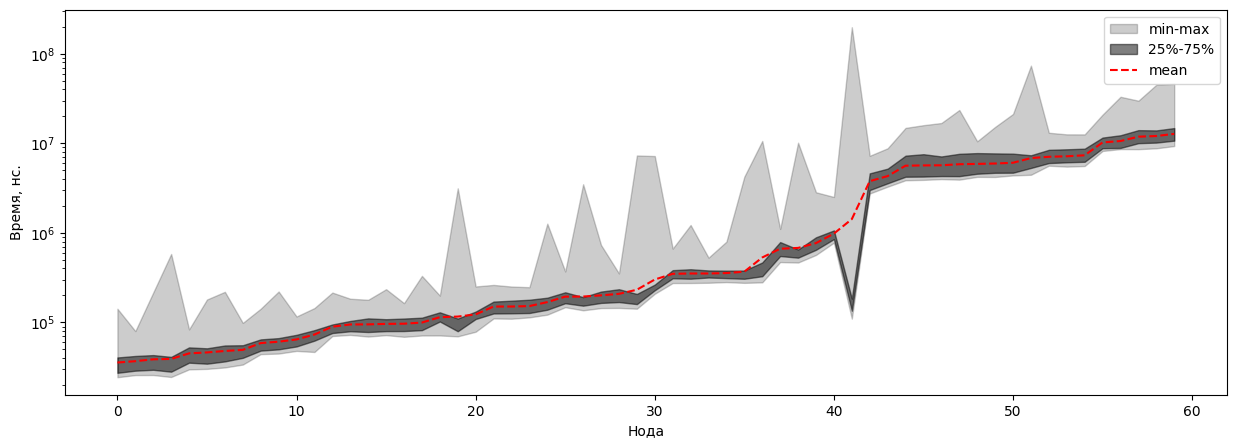

In [10]:
plt.figure(figsize=(15,5))

sorted_measurments = df.sort_values(by='mean')

x = range(len(sorted_measurments))

plt.fill_between(x, sorted_measurments['min'], sorted_measurments['max'],
                 label='min-max', alpha=0.2, color='black')
plt.fill_between(x, sorted_measurments['25%'], sorted_measurments['75%'],
                 label='25%-75%', alpha=0.5, color='black')

plt.plot(x, sorted_measurments['mean'], label='mean', color='red', linestyle='--')

plt.yscale('log')
plt.ylabel('Время, нс.')
plt.xlabel('Нода')
plt.legend();